# 1. 데이터 로드

### 주요 import 할것들 미리 해두기 (나머지는 그때그때)

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime as dt
from datetime import timedelta as td

In [2]:
import utils

### 경로 등 global config 설정

In [3]:
RAW_ROOT = 'raw'
DATA_ROOT = 'data'

### 각종 데이터 불러오기

In [4]:
%%time
df_user_raw, df_item_raw, df_log_raw, df_sub_raw = utils.load_raw(RAW_ROOT)

CPU times: user 12.9 s, sys: 6.63 s, total: 19.6 s
Wall time: 18.4 s


In [5]:
%%time
df_user = pd.read_parquet(f'{DATA_ROOT}/df_user_preprocessed.pq')
df_item = pd.read_parquet(f'{DATA_ROOT}/df_item_preprocessed.pq')
df_log_all = pd.read_parquet(f'{DATA_ROOT}/df_log_preprocessed.pq')

CPU times: user 11.7 s, sys: 6.93 s, total: 18.6 s
Wall time: 16.6 s


### 중요!!! CV, LB 설정

즉, 두번 돌려야함

In [6]:
DNAME = 'LB'

In [7]:
%%time
df_log = utils.get_df_log_of(df_log_all, DNAME)
df_log = df_log[df_log['target'] != 'test']

CPU times: user 8.11 s, sys: 3.76 s, total: 11.9 s
Wall time: 11.3 s


In [8]:
del df_log_all

---

# 2. Sales Channel 관련

온라인인지 오프라인인지 확률. 기본값은 분포대로.

In [9]:
df_channel_count = df_log['sales_channel_id'].value_counts()
df_channel_count

2    10780517
1     4240397
Name: sales_channel_id, dtype: int64

In [10]:
global_online_prob = df_channel_count.loc[2] / (df_channel_count.loc[2] + df_channel_count.loc[1])
global_online_prob

0.7177004674948542

우선 count에 대한 aggregate 부터

In [11]:
%%time
ss_sc_online_count = df_log[df_log['sales_channel_id'] == 2].groupby('customer_id').size()
ss_sc_offline_count = df_log[df_log['sales_channel_id'] == 1].groupby('customer_id').size()

CPU times: user 6.92 s, sys: 850 ms, total: 7.77 s
Wall time: 7.68 s


둘 다 0이라서 NaN 뜨면 그때 글로벌 기본값 사용

In [12]:
df_user['online_prob'] = ss_sc_online_count / (ss_sc_online_count + ss_sc_offline_count)

In [13]:
del ss_sc_online_count
del ss_sc_offline_count

<AxesSubplot:ylabel='Frequency'>

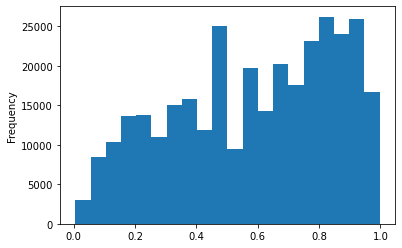

In [14]:
df_user[~df_user['online_prob'].isna()]['online_prob'].plot.hist(bins=20)

In [15]:
df_user['online_prob'].fillna(global_online_prob, inplace=True)

---

# 3. Cohort 관련

이름 붙이기가 애매하네. 원래는 index임.

출처: https://www.kaggle.com/code/junjitakeshima/h-m-easy-grouping-by-sex-attribute-age-en-jp

In [16]:
df_item_with_cohort_group = df_item.copy()

In [17]:
df_item_with_cohort_group['index_code'].unique()

array(['A', 'B', 'G', 'F', 'C', 'S', 'H', 'D', 'I', 'J'], dtype=object)

In [18]:
df_item_with_cohort_group['cohort_group'] = df_item_with_cohort_group['index_code'].copy()

로그에 left join

In [19]:
%%time
df_log_with_cohort_group = df_log.merge(df_item_with_cohort_group['cohort_group'], how='left', left_on='article_id', right_index=True)

CPU times: user 4.19 s, sys: 835 ms, total: 5.03 s
Wall time: 5.02 s


In [20]:
del df_item_with_cohort_group

로그 기준 글로벌 분포 재두기 (fillna용)

<AxesSubplot:ylabel='cohort_group'>

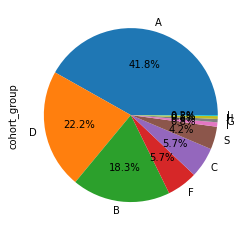

In [21]:
df_cohort_count = df_log_with_cohort_group['cohort_group'].value_counts()
df_cohort_count.plot(kind='pie', autopct='%1.1f%%')

In [22]:
df_cohort_count

A    6284751
D    3327764
B    2743637
F     854680
C     851103
S     635386
I     123211
G      93039
H      79063
J      28280
Name: cohort_group, dtype: int64

In [23]:
df_cohort_dist = df_cohort_count.copy()
df_cohort_dist = df_cohort_dist / df_cohort_dist.sum()
df_cohort_dist

A    0.418400
D    0.221542
B    0.182654
F    0.056899
C    0.056661
S    0.042300
I    0.008203
G    0.006194
H    0.005264
J    0.001883
Name: cohort_group, dtype: float64

유저쪽으로 aggregate.

NaN은 확실히 0개라는뜻.

In [24]:
cohort_group_columns = ['A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'S']

In [25]:
%%time
df_user_of_cohort_group_counts = df_log_with_cohort_group[['customer_id', 'article_id', 'cohort_group']].groupby(['customer_id', 'cohort_group']).count().unstack()
df_user_of_cohort_group_counts.fillna(0, inplace=True)
df_user_of_cohort_group_counts.columns = cohort_group_columns

CPU times: user 10.7 s, sys: 2.18 s, total: 12.8 s
Wall time: 12.8 s


In [26]:
del df_log_with_cohort_group

비율로 저장해서 붙이기

In [27]:
df_user_of_cohort_group_dist = df_user_of_cohort_group_counts.div(df_user_of_cohort_group_counts.sum(1), axis='index')
df_user_of_cohort_group_dist.columns = [f'cohort_prob_{code}' for code in cohort_group_columns]
df_user = df_user.merge(df_user_of_cohort_group_dist, how='left', left_index=True, right_index=True)

In [28]:
del df_user_of_cohort_group_dist
del df_user_of_cohort_group_counts

나누기 하느라 발생한 NaN들은 위에서 얻은 디폴트 분포값으로 채우기

In [29]:
for code in cohort_group_columns:
    df_user[f'cohort_prob_{code}'].fillna(df_cohort_dist.loc[code], inplace=True)

In [30]:
df_user.isna().sum()

FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age                       0
age_gmm_1                 0
age_gmm_2                 0
online_prob               0
cohort_prob_A             0
cohort_prob_B             0
cohort_prob_C             0
cohort_prob_D             0
cohort_prob_F             0
cohort_prob_G             0
cohort_prob_H             0
cohort_prob_I             0
cohort_prob_J             0
cohort_prob_S             0
dtype: int64

---

# 4. Garment 관련

이것도 원래는 garment group

cohort와 완전 동일하게 진행, 단 unknown인 -1은 제외.

In [31]:
df_item_with_garment_group = df_item.copy()

In [32]:
df_item_with_garment_group['garment_group_no'].unique()

array([1002, 1017, 1021, 1005, 1019, 1016, 1007, 1020, 1018, 1003, 1011,
       1009, 1008, 1025, 1013, 1012, 1023, 1010,   -1, 1006, 1014])

In [33]:
df_item_with_garment_group['garment_group'] = df_item_with_garment_group['garment_group_no'].copy()
df_item_with_garment_group = df_item_with_garment_group[df_item_with_garment_group['garment_group'] != -1]

로그에 left join

In [34]:
%%time
df_log_with_garment_group = df_log.merge(df_item_with_garment_group['garment_group'], how='inner', left_on='article_id', right_index=True)
df_log_with_garment_group = df_log_with_garment_group.astype({
    'garment_group': int,
})

CPU times: user 17.2 s, sys: 2.2 s, total: 19.4 s
Wall time: 19.3 s


In [35]:
del df_item_with_garment_group

로그 기준 글로벌 분포 재두기 (fillna용)

<AxesSubplot:ylabel='garment_group'>

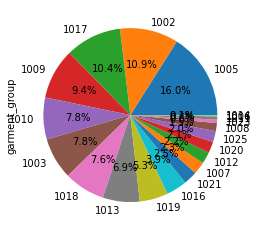

In [36]:
df_garment_count = df_log_with_garment_group['garment_group'].value_counts()
df_garment_count.plot(kind='pie', autopct='%1.1f%%')

In [37]:
df_garment_count

1005    2386009
1002    1619527
1017    1553633
1009    1397844
1010    1155637
1003    1155521
1018    1132859
1013    1020026
1019     786699
1016     575233
1021     377816
1007     340683
1012     325429
1020     312160
1025     304446
1008     220806
1023      93226
1011      91291
1006      20804
1014      13770
Name: garment_group, dtype: int64

In [38]:
df_garment_dist = df_garment_count.copy()
df_garment_dist = df_garment_dist / df_garment_dist.sum()
df_garment_dist

1005    0.160313
1002    0.108814
1017    0.104387
1009    0.093920
1010    0.077646
1003    0.077638
1018    0.076116
1013    0.068534
1019    0.052857
1016    0.038649
1021    0.025385
1007    0.022890
1012    0.021865
1020    0.020974
1025    0.020455
1008    0.014836
1023    0.006264
1011    0.006134
1006    0.001398
1014    0.000925
Name: garment_group, dtype: float64

유저쪽으로 aggregate.

NaN은 확실히 0개라는뜻.

In [39]:
%%time
df_user_of_garment_group_counts = df_log_with_garment_group[['customer_id', 'article_id', 'garment_group']].groupby(['customer_id', 'garment_group']).count().unstack()
df_user_of_garment_group_counts.fillna(0, inplace=True)
df_user_of_garment_group_counts.columns = [f'garment_prob_{garment_group}' for _, garment_group in df_user_of_garment_group_counts.columns.to_list()]

CPU times: user 15.4 s, sys: 2.16 s, total: 17.5 s
Wall time: 17.5 s


In [40]:
del df_log_with_garment_group

비율로 저장해서 붙이기

In [41]:
df_user_of_garment_group_dist = df_user_of_garment_group_counts.div(df_user_of_garment_group_counts.sum(1), axis='index')
df_user = df_user.merge(df_user_of_garment_group_dist, how='left', left_index=True, right_index=True)

In [42]:
del df_user_of_garment_group_dist
del df_user_of_garment_group_counts

나누기 하느라 발생한 NaN들은 위에서 얻은 디폴트 분포값으로 채우기

In [43]:
for index in df_garment_dist.index.to_list():
    df_user[f'garment_prob_{index}'].fillna(df_garment_dist.loc[index], inplace=True)

In [44]:
df_user.isna().sum()

FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age                       0
age_gmm_1                 0
age_gmm_2                 0
online_prob               0
cohort_prob_A             0
cohort_prob_B             0
cohort_prob_C             0
cohort_prob_D             0
cohort_prob_F             0
cohort_prob_G             0
cohort_prob_H             0
cohort_prob_I             0
cohort_prob_J             0
cohort_prob_S             0
garment_prob_1002         0
garment_prob_1003         0
garment_prob_1005         0
garment_prob_1006         0
garment_prob_1007         0
garment_prob_1008         0
garment_prob_1009         0
garment_prob_1010         0
garment_prob_1011         0
garment_prob_1012         0
garment_prob_1013         0
garment_prob_1014         0
garment_prob_1016         0
garment_prob_1017         0
garment_prob_1018         0
garment_prob_1019         0
garment_prob_1020         0
garment_prob_1021   

---

# 5. Price 관련

우선 분포부터 확인

CPU times: user 1.52 s, sys: 403 ms, total: 1.93 s
Wall time: 1.92 s


<AxesSubplot:ylabel='Frequency'>

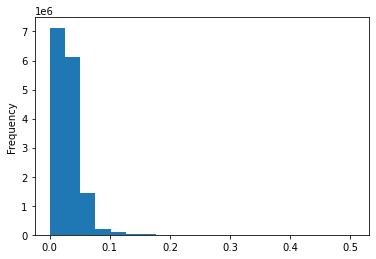

In [45]:
%%time
df_log['price'].plot.hist(bins=20)

유저별 평균 가격

In [46]:
%%time
df_user_of_avg_price = df_log.groupby('customer_id')['price'].mean('price')
df_user_of_avg_price.name = 'avg_price'

CPU times: user 5.02 s, sys: 157 ms, total: 5.18 s
Wall time: 5.17 s


글로벌 평균 가격 (fillna용)

In [47]:
global_avg_price = df_log['price'].mean()
global_avg_price

0.028251888996179735

In [48]:
df_user = df_user.merge(df_user_of_avg_price, how='left', left_index=True, right_index=True)
df_user['avg_price'].fillna(global_avg_price, inplace=True)

<AxesSubplot:ylabel='Frequency'>

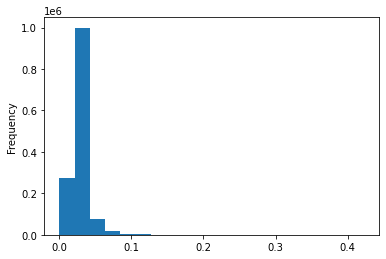

In [49]:
df_user['avg_price'].plot.hist(bins=20)

In [50]:
df_user.isna().sum()

FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age                       0
age_gmm_1                 0
age_gmm_2                 0
online_prob               0
cohort_prob_A             0
cohort_prob_B             0
cohort_prob_C             0
cohort_prob_D             0
cohort_prob_F             0
cohort_prob_G             0
cohort_prob_H             0
cohort_prob_I             0
cohort_prob_J             0
cohort_prob_S             0
garment_prob_1002         0
garment_prob_1003         0
garment_prob_1005         0
garment_prob_1006         0
garment_prob_1007         0
garment_prob_1008         0
garment_prob_1009         0
garment_prob_1010         0
garment_prob_1011         0
garment_prob_1012         0
garment_prob_1013         0
garment_prob_1014         0
garment_prob_1016         0
garment_prob_1017         0
garment_prob_1018         0
garment_prob_1019         0
garment_prob_1020         0
garment_prob_1021   

---

# 6. Transaction Count 관련

In [51]:
%%time
ss_transaction_count = df_log.groupby('customer_id').size()
ss_transaction_count.name = 'transaction_count'

CPU times: user 4.92 s, sys: 199 ms, total: 5.12 s
Wall time: 5.11 s


In [52]:
df_user = df_user.merge(ss_transaction_count, how='left', left_index=True, right_index=True)
df_user['transaction_count'].fillna(0, inplace=True)

In [53]:
del ss_transaction_count

CPU times: user 234 ms, sys: 417 µs, total: 234 ms
Wall time: 234 ms


<AxesSubplot:ylabel='Frequency'>

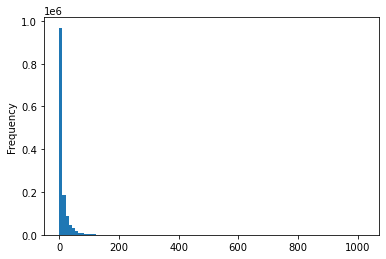

In [54]:
%%time
df_user['transaction_count'].plot.hist(bins=100)

In [55]:
print(f"total user: {len(df_user)}")
print(f"transaction count 50% percentile: {int(np.percentile(df_user['transaction_count'], 50))}")
print(f"transaction count 99% percentile: {int(np.percentile(df_user['transaction_count'], 99))}")

total user: 1371980
transaction count 50% percentile: 4
transaction count 99% percentile: 93


In [56]:
cold_threshold = int(np.percentile(df_user['transaction_count'], 50))
df_user['is_cold'] = 0
df_user.loc[df_user['transaction_count'] < cold_threshold, 'is_cold'] = 1

In [57]:
df_user['is_new'] = 0
df_user.loc[df_user['transaction_count'] < 1, 'is_new'] = 1

In [58]:
df_user['log_transaction_count'] = np.log(1 + df_user['transaction_count'])

In [59]:
df_user.isna().sum()

FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age                       0
age_gmm_1                 0
age_gmm_2                 0
online_prob               0
cohort_prob_A             0
cohort_prob_B             0
cohort_prob_C             0
cohort_prob_D             0
cohort_prob_F             0
cohort_prob_G             0
cohort_prob_H             0
cohort_prob_I             0
cohort_prob_J             0
cohort_prob_S             0
garment_prob_1002         0
garment_prob_1003         0
garment_prob_1005         0
garment_prob_1006         0
garment_prob_1007         0
garment_prob_1008         0
garment_prob_1009         0
garment_prob_1010         0
garment_prob_1011         0
garment_prob_1012         0
garment_prob_1013         0
garment_prob_1014         0
garment_prob_1016         0
garment_prob_1017         0
garment_prob_1018         0
garment_prob_1019         0
garment_prob_1020         0
garment_prob_1021   

---

# 7. Week 관련

In [60]:
%%time
df_user_of_week = df_log.groupby('customer_id').aggregate({'week': 'max'})
df_user_of_week.columns = ['last_active_week']

CPU times: user 5.12 s, sys: 184 ms, total: 5.3 s
Wall time: 5.29 s


In [61]:
df_user = df_user.merge(df_user_of_week, how='left', left_index=True, right_index=True)
df_user['last_active_week'].fillna(0, inplace=True)
df_user = df_user.astype({
    'last_active_week': int,
})

CPU times: user 479 ms, sys: 314 ms, total: 793 ms
Wall time: 784 ms


<AxesSubplot:ylabel='Frequency'>

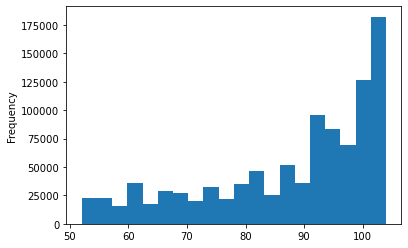

In [62]:
%%time
df_user[df_user['last_active_week'] > 0]['last_active_week'].plot.hist(bins=20)

In [63]:
df_user.isna().sum()

FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age                       0
age_gmm_1                 0
age_gmm_2                 0
online_prob               0
cohort_prob_A             0
cohort_prob_B             0
cohort_prob_C             0
cohort_prob_D             0
cohort_prob_F             0
cohort_prob_G             0
cohort_prob_H             0
cohort_prob_I             0
cohort_prob_J             0
cohort_prob_S             0
garment_prob_1002         0
garment_prob_1003         0
garment_prob_1005         0
garment_prob_1006         0
garment_prob_1007         0
garment_prob_1008         0
garment_prob_1009         0
garment_prob_1010         0
garment_prob_1011         0
garment_prob_1012         0
garment_prob_1013         0
garment_prob_1014         0
garment_prob_1016         0
garment_prob_1017         0
garment_prob_1018         0
garment_prob_1019         0
garment_prob_1020         0
garment_prob_1021   

---

# 8. Aggregated 버전 저장

최종 데이터 확인

In [64]:
df_user

,FN,Active,club_member_status,fashion_news_frequency,age,age_gmm_1,age_gmm_2,online_prob,cohort_prob_A,cohort_prob_B,...,garment_prob_1020,garment_prob_1021,garment_prob_1023,garment_prob_1025,avg_price,transaction_count,is_cold,is_new,log_transaction_count,last_active_week
customer_id,,,,,,,,,,,,,,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0,0,1,0,49.0,-0.035845,4.973913,0.666667,0.750000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.029095,12.0,0,0,2.564949,102
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,0,0,1,0,25.0,-2.415854,-0.068474,0.942857,0.114286,0.628571,...,0.000000,0.000000,0.000000,0.000000,0.025358,35.0,0,0,3.583519,94
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0,0,1,0,24.0,-2.515021,-0.278574,0.717700,0.357143,0.214286,...,0.000000,0.000000,0.000000,0.000000,0.039935,14.0,0,0,2.708050,103
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0,0,1,0,54.0,0.459991,6.024411,0.717700,0.418400,0.182654,...,0.020974,0.025385,0.006264,0.020455,0.028252,0.0,1,1,0.000000,0
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,1,1,1,1,52.0,0.261657,5.604212,0.717700,0.444444,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.039955,9.0,0,0,2.302585,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831,0,0,1,0,24.0,-2.515021,-0.278574,0.571429,0.071429,0.642857,...,0.000000,0.035714,0.000000,0.000000,0.022683,28.0,0,0,3.367296,102
ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53481233731b5c4f8b7,0,0,1,0,21.0,-2.812523,-0.908872,0.750000,0.142857,0.142857,...,0.000000,0.000000,0.000000,0.000000,0.021416,56.0,0,0,4.043051,99
ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264,1,1,1,1,21.0,-2.812523,-0.908872,0.600000,0.400000,0.000000,...,0.000000,0.000000,0.066667,0.000000,0.017520,15.0,0,0,2.772589,103


아직 one-hot encoding 등을 안했으니 feature라고 하긴 좀 그렇고, 대신 aggregation 포함된 전처리는 전부 되어있는것임.

In [65]:
%%time
df_user.to_parquet(f'{DATA_ROOT}/df_user_aggregated_{DNAME}.pq')

CPU times: user 2.41 s, sys: 313 ms, total: 2.73 s
Wall time: 2.15 s


In [66]:
del df_user

In [67]:
del df_log

In [68]:
del df_user_raw
del df_item_raw
del df_log_raw
del df_sub_raw

---

# 9. 유저 Feature 만들기

여기서부턴 거의 딥러닝을 위한것. 컬럼 막 지우고 그럼.

In [69]:
%%time
df_user = pd.read_parquet(f'{DATA_ROOT}/df_user_aggregated_{DNAME}.pq')

CPU times: user 1.36 s, sys: 1.36 s, total: 2.72 s
Wall time: 1.67 s


In [70]:
df_user_feature = df_user.copy()

In [71]:
del df_user

In [72]:
df_user_feature.drop(columns=[
    'age',
    'transaction_count',
], inplace=True)

In [73]:
one_hot_fields = [
    'FN',
    'Active',
    'club_member_status',
    'fashion_news_frequency',
    'is_cold',
]

In [74]:
for field in one_hot_fields:
    hotted = pd.get_dummies(df_user_feature[field], prefix=field)
    df_user_feature = df_user_feature.merge(hotted, how='left', left_index=True, right_index=True)
    df_user_feature.drop(columns=[field], inplace=True)

NaN 체크

In [75]:
df_user_feature.isna().sum()

age_gmm_1                   0
age_gmm_2                   0
online_prob                 0
cohort_prob_A               0
cohort_prob_B               0
cohort_prob_C               0
cohort_prob_D               0
cohort_prob_F               0
cohort_prob_G               0
cohort_prob_H               0
cohort_prob_I               0
cohort_prob_J               0
cohort_prob_S               0
garment_prob_1002           0
garment_prob_1003           0
garment_prob_1005           0
garment_prob_1006           0
garment_prob_1007           0
garment_prob_1008           0
garment_prob_1009           0
garment_prob_1010           0
garment_prob_1011           0
garment_prob_1012           0
garment_prob_1013           0
garment_prob_1014           0
garment_prob_1016           0
garment_prob_1017           0
garment_prob_1018           0
garment_prob_1019           0
garment_prob_1020           0
garment_prob_1021           0
garment_prob_1023           0
garment_prob_1025           0
avg_price 

최종 확인

In [76]:
df_user_feature

,age_gmm_1,age_gmm_2,online_prob,cohort_prob_A,cohort_prob_B,cohort_prob_C,cohort_prob_D,cohort_prob_F,cohort_prob_G,cohort_prob_H,...,FN_0,FN_1,Active_0,Active_1,club_member_status_0,club_member_status_1,fashion_news_frequency_0,fashion_news_frequency_1,is_cold_0,is_cold_1
customer_id,,,,,,,,,,,,,,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,-0.035845,4.973913,0.666667,0.750000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,...,1,0,1,0,0,1,1,0,1,0
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,-2.415854,-0.068474,0.942857,0.114286,0.628571,0.000000,0.114286,0.000000,0.114286,0.000000,...,1,0,1,0,0,1,1,0,1,0
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,-2.515021,-0.278574,0.717700,0.357143,0.214286,0.000000,0.071429,0.285714,0.000000,0.000000,...,1,0,1,0,0,1,1,0,1,0
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0.459991,6.024411,0.717700,0.418400,0.182654,0.056661,0.221542,0.056899,0.006194,0.005264,...,1,0,1,0,0,1,1,0,0,1
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0.261657,5.604212,0.717700,0.444444,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,1,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831,-2.515021,-0.278574,0.571429,0.071429,0.642857,0.107143,0.000000,0.035714,0.000000,0.000000,...,1,0,1,0,0,1,1,0,1,0
ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53481233731b5c4f8b7,-2.812523,-0.908872,0.750000,0.142857,0.142857,0.035714,0.535714,0.017857,0.071429,0.017857,...,1,0,1,0,0,1,1,0,1,0
ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264,-2.812523,-0.908872,0.600000,0.400000,0.000000,0.000000,0.333333,0.266667,0.000000,0.000000,...,0,1,0,1,0,1,0,1,1,0


정리해서 저장

In [77]:
%%time
df_user_feature.to_parquet(f'{DATA_ROOT}/df_user_feature_{DNAME}.pq')

CPU times: user 2.49 s, sys: 292 ms, total: 2.79 s
Wall time: 2.22 s


last active week는 좀 특별 취급

In [78]:
uid2law = {}
for uid, law in df_user_feature[['last_active_week']].reset_index().values:
    uid2law[uid] = law
df_user_feature.drop(columns=['last_active_week'], inplace=True)

In [79]:
with open(f'{DATA_ROOT}/uid2law_{DNAME}.pkl', 'wb') as fp:
    pickle.dump(uid2law, fp)

In [80]:
del uid2law

feature인 상태로 저장

In [81]:
uid2feature = {}
for row in df_user_feature.reset_index().values:
    uid = row[0]
    feature = tuple(row[1:])
    uid2feature[uid] = feature

In [82]:
with open(f'{DATA_ROOT}/uid2feature_{DNAME}.pkl', 'wb') as fp:
    pickle.dump(uid2feature, fp)

In [83]:
del uid2feature

agg 없는 버전도 따로 만들어서 저장 (나중에 추가한 코드라 약간 일관성이 떨어짐ㅎㅎ)

근데 생각해보니 online과 price는... 너무 중요한 feature고 근데 트랜잭션 정보를 inference 타임에 활용할수가 없으니까; 그냥 알고 있다고 가정하는게 맞는것 같더라구.. 그래서 걔네들은 살림ㅇㅇ..

In [84]:
noagg_fields = [
    'age_gmm_1',
    'age_gmm_2',
    'FN_0',
    'FN_1',
    'Active_0',
    'Active_1',
    'club_member_status_0',
    'club_member_status_1',
    'fashion_news_frequency_0',
    'fashion_news_frequency_1',
    'avg_price',
    'online_prob',
]

In [85]:
df_user_feature_noagg = df_user_feature[noagg_fields]

In [86]:
uid2feature_noagg = {}
for row in df_user_feature_noagg.reset_index().values:
    uid = row[0]
    feature = tuple(row[1:])
    uid2feature_noagg[uid] = feature

In [87]:
with open(f'{DATA_ROOT}/uid2feature_noagg_{DNAME}.pkl', 'wb') as fp:
    pickle.dump(uid2feature_noagg, fp)

In [88]:
del uid2feature_noagg

In [89]:
del df_user_feature_noagg
del df_user_feature